In [ ]:
import os

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import random
import seaborn as sns

#preprocessing
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from spacy.lang.en.stop_words import STOP_WORDS

#model
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
from sklearn import metrics
from sklearn.svm import SVC

#eval
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc
from yellowbrick.classifier import ROCAUC
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import learning_curve



In [ ]:
#connect to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#select data
data = pd.read_csv('/content/drive/MyDrive/AI/cyberbullying_tweets.csv')


In [ ]:
#preprocessing
#split data

X_train, X_test, y_train, y_test = train_test_split(data['tweet_text'], data['cyberbullying_type'], test_size=0.2, random_state=42)

#text preprocessing
ps = PorterStemmer()

def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters
    text = re.sub(r'\W', ' ', text)

    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)

    # Remove stopwords and perform stemming
    text = ' '.join([ps.stem(word) for word in text.split() if word not in STOP_WORDS])

    return text

#apply preprocess
X_train = X_train.apply(clean_text)
X_train = X_train[X_train.str.split().str.len() >= 3]
y_train = y_train[X_train.index]

X_test = X_test.apply(clean_text)
X_test = X_test[X_test.str.split().str.len() >= 3]
y_test = y_test[X_test.index]

In [ ]:
# Pipeline for SVM
pipeline_svm = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('svd', TruncatedSVD(n_components=100)),  # Reducing to 100 components as an example
    ('clf', SVC(kernel='linear', probability=True))  # Linear SVM
])

# Fit SVM model
pipeline_svm.fit(X_train, y_train)
predictions_svm = pipeline_svm.predict(X_test)
predictions_prob_svm = pipeline_svm.predict_proba(X_test)

In [ ]:
#model eval
print("SVM Classification Report:")
print(classification_report(y_test,predictions_svm,digits=5))

SVM Classification Report:
                     precision    recall  f1-score   support

                age    0.93468   0.98437   0.95888      1599
          ethnicity    0.96375   0.96556   0.96465      1597
             gender    0.90023   0.78538   0.83889      1505
  not_cyberbullying    0.57100   0.49802   0.53202      1518
other_cyberbullying    0.55824   0.69129   0.61768      1435
           religion    0.93951   0.91310   0.92612      1565

           accuracy                        0.81083      9219
          macro avg    0.81124   0.80629   0.80637      9219
       weighted avg    0.81643   0.81083   0.81133      9219



ROC-AUC :  0.960205


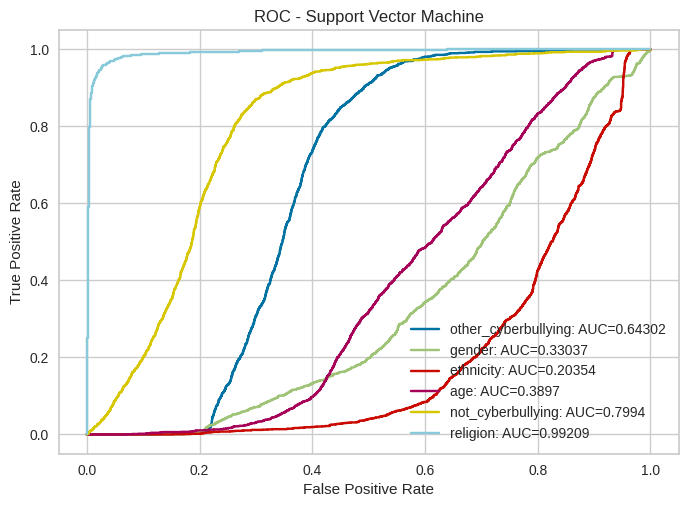

In [ ]:
#roc-auc
print("ROC-AUC : ", round(roc_auc_score(y_test, predictions_prob_svm, multi_class='ovr'), 6))

classes = y_train.unique().tolist()
y_test = label_binarize(y_test, classes=classes)
y_test[0:6, :]

fpr_rf = dict()
tpr_rf = dict()

# for each class
for i in range(len(classes)):

    # determine precision and recall at various thresholds
    # in a 1 vs all fashion
    fpr_rf[i], tpr_rf[i], _ = roc_curve(
        y_test[:, i], predictions_prob_svm[:, i])

    plt.plot(fpr_rf[i], tpr_rf[i], label=f'{classes[i]}: AUC={round(auc(fpr_rf[i], tpr_rf[i]),5)}')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Support Vector Machine')
plt.legend(loc="lower right")
plt.show()

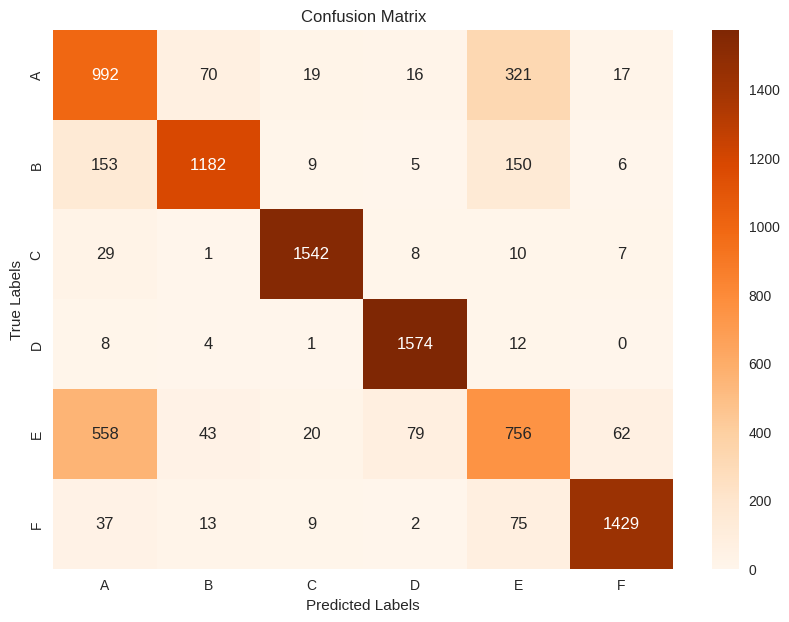

In [ ]:
#confusion matrix
label_map = {'other_cyberbullying' : 0,  'gender' : 1, 'ethnicity' : 2, 'age' : 3, 'not_cyberbullying' : 4, 'religion' : 5}
y_pred_integers = np.array([label_map[label] for label in predictions_svm])
c_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_integers)

# print(c_matrix)

# Example confusion matrix (replace with your actual data)
conf_matrix = np.array(c_matrix)

# Create a DataFrame for better labeling
class_labels = ['A', 'B', 'C', 'D', 'E', 'F']
df_cm = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, cmap='Oranges', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


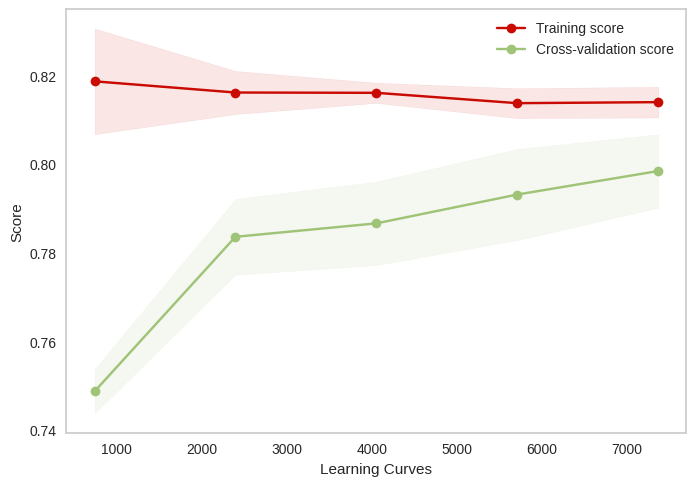

In [ ]:
#learning curve
train_sizes, train_scores, valid_scores = learning_curve(pipeline_svm, X_test, y_test, cv = 5)

train_scores_mean = np.mean(train_scores, axis = 1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Learning Curves")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.show()